In [1]:
import sys
sys.path.append('./notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
_d = np.load('../data/data_clean2_128_train.npz')
X = _d['X']
Y = _d['Y']

# Turn labels into boolean present/missing
Y_binary = np.sum(np.sum(Y, axis=2), axis=1) > 0
Y_binary = Y_binary.astype(np.float32)

In [3]:
# Also load the non-filtered data for evaluation
_d = np.load('../data/data_128_train.npz')
X_full = _d['X'][:,None,:,:]
Y_full = _d['Y'][:,None,:,:]

Y_full_binary = np.sum(np.sum(Y_full, axis=2), axis=2).squeeze() > 0
Y_full_binary = Y_full_binary.astype(np.float32)

In [4]:
nbp_pixels = np.sum(np.sum(np.sum(Y_full, axis=1), axis=1), axis=1)

bpvisible = nbp_pixels > 0

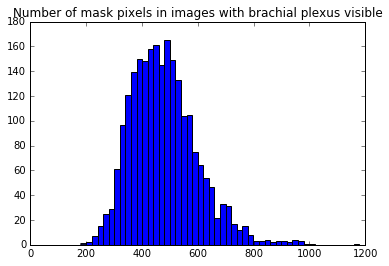

In [5]:
pl.figure()
pl.title('Number of mask pixels in images with brachial plexus visible')
_ = pl.hist(nbp_pixels[bpvisible], bins=50)

In [6]:
nbp_pixels[bpvisible].min()

181.0

In [7]:
print "%.2f%% with masks" % (100 * np.count_nonzero(Y_binary) / float(len(Y_binary)))

58.49% with masks


# Fit ellipse to train masks

In [8]:
import skimage

# Draw elipsis on image
def find_ellipse(mask, draw=True):
    mask = skimage.img_as_ubyte(mask.squeeze())
    ret, thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    has_ellipse = len(contours) > 0
    ellipse = None
    if has_ellipse:
        if len(contours) > 1:
            # select largest contour
            areas = [cv2.contourArea(cnt) for cnt in contours]
            cnt = contours[np.argmax(areas)]
        else:
            cnt = contours[0]
        ellipse = cv2.fitEllipse(cnt)
        
    return has_ellipse, ellipse

def draw_ellipse(ellipse):
    img = np.zeros((128, 128, 3), dtype=np.uint8)
    cx, cy = ellipse[0:2]
    ax, ay = ellipse[2:4]
    angle = ellipse[4]
    # need to make all parameters int otherwise fallback on the ellipse(box) one
    cv2.ellipse(img, (int(cx), int(cy)), (int(ax/2), int(ay/2)), int(angle), 0, 360, (0, 255, 0), 1)
    return img

In [9]:
# compute the ellipse of the image with masks
ellipses = []
for i in np.flatnonzero(Y_full_binary > 0):
    has_ellipse, ellipse = find_ellipse(Y_full[i])
    assert has_ellipse
    angle = ellipse[2]
    ellipses.append(ellipse[0] + ellipse[1] + (ellipse[2],))
ellipses = np.array(ellipses)

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float32 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


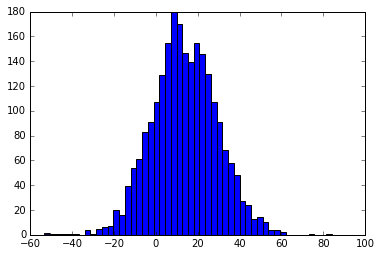

In [10]:
angles = ellipses[:,4].copy()
# Transform angle > 90 into negative angles, so the angle distribution is centered on 0
mask = angles > 90
angles[mask] = angles[mask] - 180

ellipses2 = ellipses.copy()
ellipses2[:,4] = angles

pl.hist(angles, bins=50);

[  65.62187958   32.66310501   11.69072628   41.77441406  179.72509766]
[ 65.62187958  32.66310501  11.69072628  41.77441406  -0.27490234]


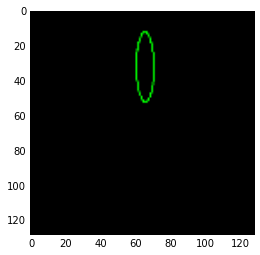

In [11]:
i = np.flatnonzero(mask)[50]
pl.figure()
print ellipses[i]
print ellipses2[i]
pl.imshow(draw_ellipse(ellipses[i]))
pl.imshow(draw_ellipse(ellipses2[i]), alpha=0.5)

In [12]:
# ellipses are (cx, cy), (ax, ay), angle

## Histograms of ellipse parameters

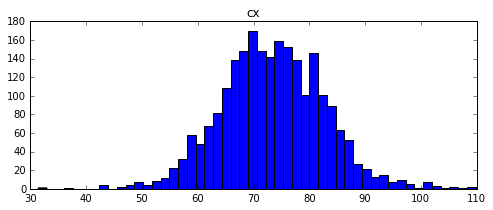

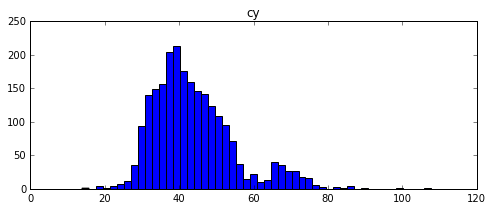

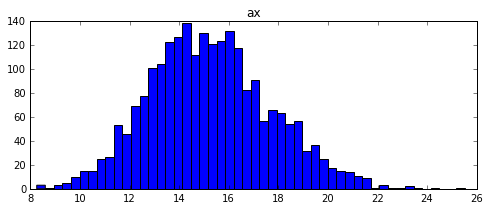

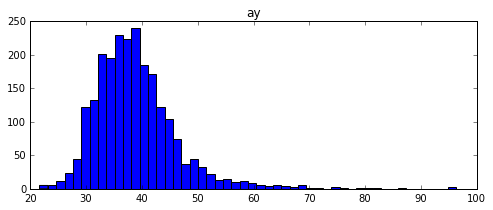

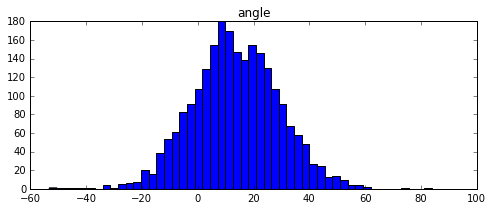

In [13]:
for i, name in enumerate(['cx', 'cy', 'ax', 'ay', 'angle']):
    pl.figure(figsize=(8, 3))
    pl.title(name)
    pl.hist(ellipses2[:,i], bins=50)

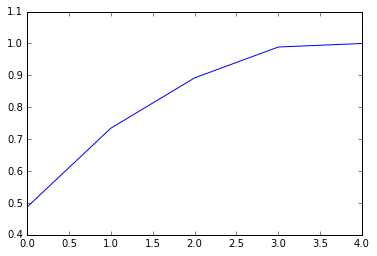

In [14]:
from sklearn.decomposition import PCA

pca = PCA().fit(ellipses2)
pl.plot(np.cumsum(pca.explained_variance_ratio_))

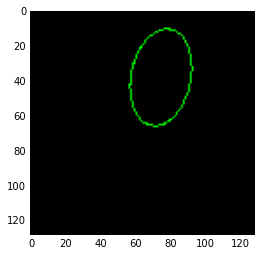

In [15]:
#pca.transform(ellipses2[5])
pl.imshow(draw_ellipse(pca.inverse_transform([0, 0, 0, -20, 20])))

# PCA on masks

In [49]:
from sklearn.decomposition import TruncatedSVD
pca2 = TruncatedSVD(n_components=20).fit(Y.reshape(-1, 128*128))

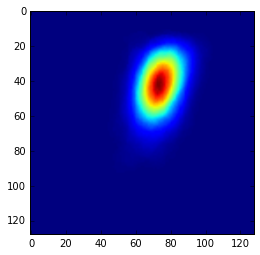

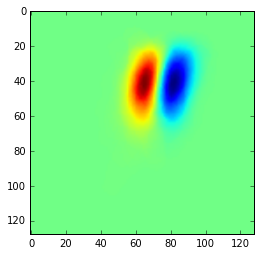

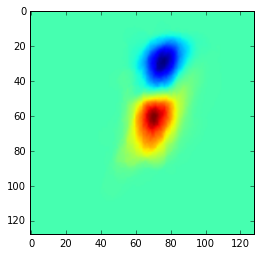

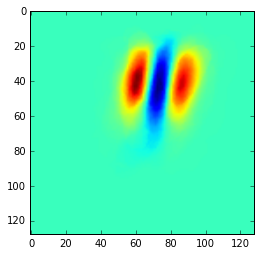

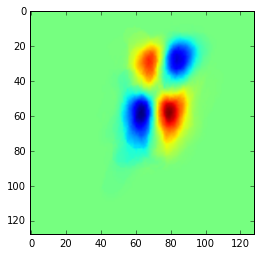

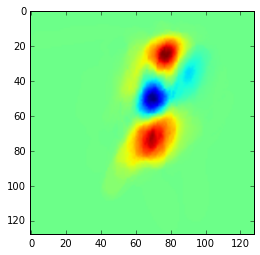

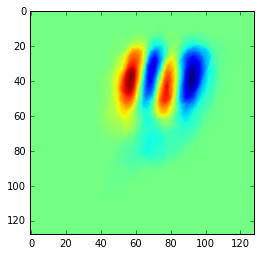

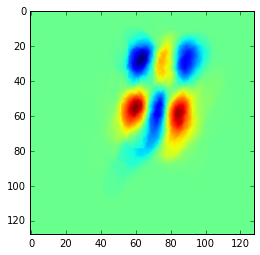

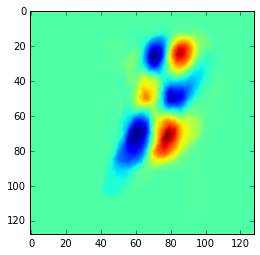

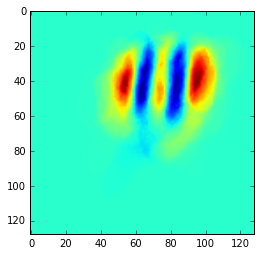

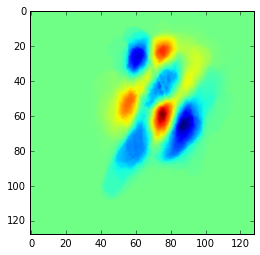

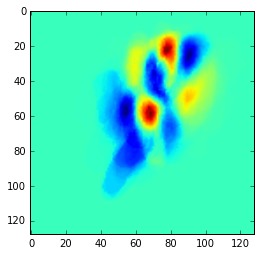

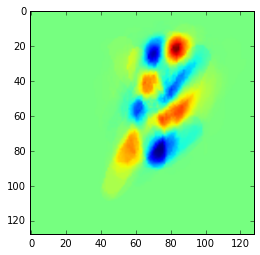

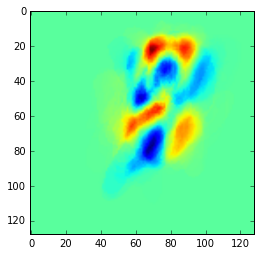

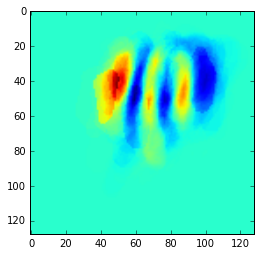

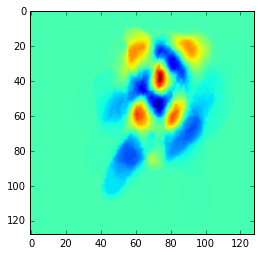

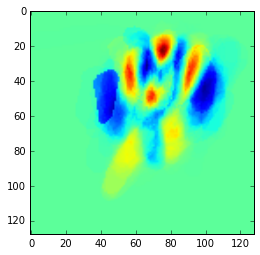

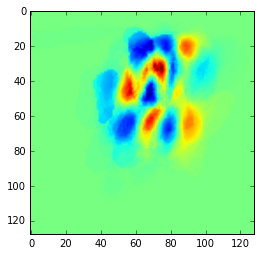

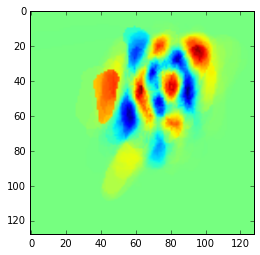

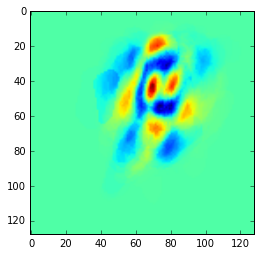

In [50]:
for i in range(pca2.components_.shape[0]):
    pl.figure()
    pl.imshow(pca2.components_[i].reshape(128, 128))

450


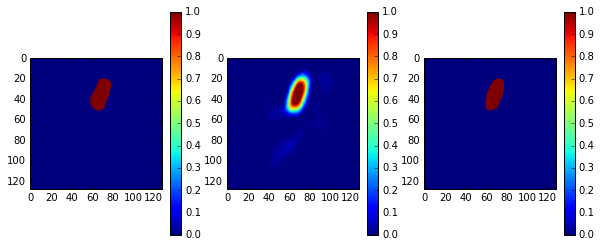

In [52]:
i = np.random.choice(np.flatnonzero(Y_binary > 0), 1)[0]
#i = 3180
print i

Y_r = pca2.transform(Y[i].reshape(-1))

pl.figure(figsize=(10, 4))
pl.subplot(131)
pl.imshow(Y[i], vmin=0, vmax=1)
pl.colorbar()
pl.subplot(132)
pl.imshow(pca2.inverse_transform(Y_r).reshape(128, 128), vmin=0, vmax=1)
pl.colorbar()
pl.subplot(133)
pl.imshow(pca2.inverse_transform(Y_r).reshape(128, 128) > 0.5, vmin=0, vmax=1)
pl.colorbar()